In [ ]:
from ad99py.ad99dask import AlexanderDunkerton1999Dask
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr


In [2]:
BFLIM = 5e-3 # MiMA AD99 spec
PATH = "/scratch/users/robcking/gwd_u_era5_2010_2020.zarr"
GCLOUD_ERA5 = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'

In [3]:
ds = xr.open_dataset(GCLOUD_ERA5,engine='zarr',chunks={},storage_options=dict(token='anon'),)

In [5]:
ds_subset = ds[['u_component_of_wind','v_component_of_wind','vertical_velocity','temperature','geopotential']]
ds_subset = ds_subset.sel(time=slice('2010-01-01','2020-01-01',6)).isel(time=0)

In [6]:
from windspharm.xarray import VectorWind
wind = VectorWind(ds_subset.u_component_of_wind,ds_subset.v_component_of_wind)

In [7]:
uchi,_,upsi,_ = wind.helmholtz()
uchiT21,_,upsiT21,_ = wind.helmholtz(truncation=21)

In [8]:
u_pert = uchi - uchiT21


In [11]:
omega_pert = ds_subset.vertical_velocity - ds_subset.vertical_velocity.mean(dim='longitude')

In [12]:
F_x = u_pert*omega_pert/9.81

In [21]:
F_x.persist()

<xarray.DataArray (level: 37, latitude: 721, longitude: 1440)> Size: 154MB
dask.array<truediv, shape=(37, 721, 1440), dtype=float32, chunksize=(37, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * level      (level) int64 296B 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
    time       datetime64[ns] 8B 2010-01-01

In [29]:
F_x70 = F_x.sel(level=70).values.ravel()
F_x70 = np.abs(F_x70)
F_x70 = F_x70[F_x70 > 0]

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00,
        6.0000e+00, 8.0000e+00, 1.0000e+01, 1.4000e+01, 1.8000e+01,
        2.5000e+01, 3.2000e+01, 4.2000e+01, 5.7000e+01, 7.6000e+01,
        1.0400e+02, 1.4600e+02, 2.2700e+02, 5.5700e+02, 1.0600e+02,
        3.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00,
        4.0000e+00, 2.0000e+00, 1.1000e+01, 2.2000e+01, 2.0000e+01,
        1.2000e+01, 3.0000e+01, 3.4000e+01, 4.1000e+01, 4.9000e+01,
        7.5000e+01, 9.6000e+01, 1.0800e+02, 1.5200e+02, 1.8800e+02,
        2.4800e+02, 3.0100e+02, 3.9300e+02, 4.9200e+02, 6.5300e+02,
        8.3900e+02, 1.0750e+03, 1.3690e+03, 1.6720e+03, 2.1560e+03,
        2.6900e+03, 3.4010e+03, 4.2320e+03, 5.4280e+03, 6.7990e+03,
        8.3430e+03, 1.0116e+04, 1.2835e+04, 1.5595e+04, 1.9025e+04,
        2.2836e+04, 2.7772e+04, 3.3657e+04, 3.8901e+04, 4.5261e+04,
        5.1823e+04, 5.8068e+04, 6.2694e+04, 6.62

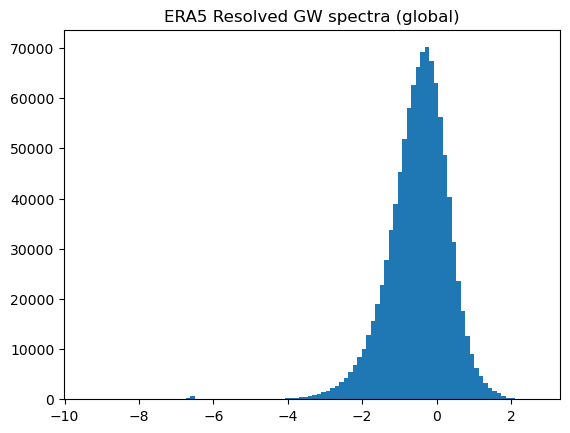

In [35]:
plt.title("ERA5 Resolved GW spectra (global)")
plt.hist(np.log10(1000*F_x70),bins=100)

In [46]:
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')

interp_mask = ds_mask_trop.interp(lat=ds_subset.latitude.values,lon=ds_subset.longitude.values,method='nearest').astype(bool)

total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)


In [52]:
total_mask = total_mask.rename(lat='latitude',lon='longitude')

In [59]:
F_x70_nonoro = F_x.sel(level=70).where(total_mask).stack(points=('latitude','longitude')).dropna('points',how='all')
F_x70_nonoro = np.abs(F_x70_nonoro.values)
F_x70_nonoro = F_x70_nonoro[F_x70_nonoro > 0]*1000

Text(0.5, 1.0, 'ERA5 Directly Resolved GW (non-orographic)')

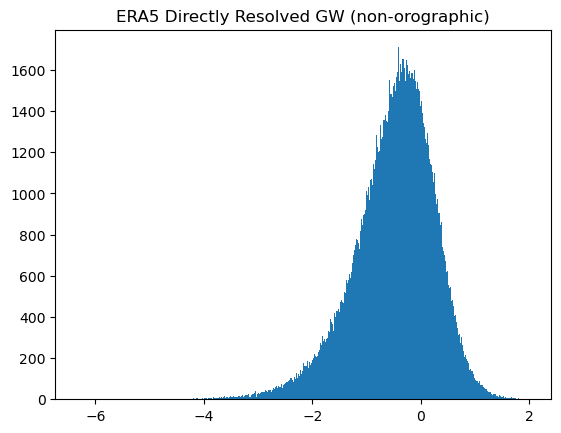

In [65]:
plt.hist(np.log10(F_x70_nonoro),bins=1000)
plt.title("ERA5 Directly Resolved GW (non-orographic)")

In [68]:
log_dist = np.log10(F_x70_nonoro)
skew =  np.mean(((log_dist - log_dist.mean())/log_dist.std())**3)

In [69]:
skew

-0.7385648